In [3]:
%pip install scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 50.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 52.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 51.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import scanpy as sc
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

# Output folders
Path("results/figures").mkdir(parents=True, exist_ok=True)
Path("results/metrics").mkdir(parents=True, exist_ok=True)
Path("results/models").mkdir(parents=True, exist_ok=True)

print("Scanpy cache dir:", sc.settings.cachedir)

Scanpy cache dir: cache


In [7]:
adata = sc.datasets.pbmc3k()  # downloads on first run, then uses cache
adata

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

print("After filtering:", adata.shape)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


After filtering: (2700, 13714)


In [11]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var["highly_variable"]].copy()

print("After HVG selection:", adata.shape)

After HVG selection: (2700, 2000)


In [15]:
%pip install igraph leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.leiden(adata, resolution=0.6)

adata.obs["label"] = adata.obs["leiden"].astype(str)
print(adata.obs["label"].value_counts())

/var/folders/07/b7qwj15d1zs41kh2whcqhh0c0000gp/T/ipykernel_53745/3801717873.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.6)


label
0    1159
1     448
2     348
3     320
4     202
5     159
6      37
7      15
8      12
Name: count, dtype: int64


In [19]:
X = adata.X
if not isinstance(X, np.ndarray):  # convert sparse -> dense for sklearn RF
    X = X.toarray()

y = adata.obs["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (2025, 2000) Test size: (675, 2000)


In [21]:
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",
    max_features="sqrt"
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Done training.")

Done training.


In [23]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).T
report_df.to_csv("results/metrics/rf_classification_report.csv")

print(classification_report(y_test, y_pred))
print("Saved: results/metrics/rf_classification_report.csv")

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       290
           1       0.92      0.96      0.94       112
           2       1.00      1.00      1.00        87
           3       0.97      0.86      0.91        80
           4       0.91      0.84      0.88        50
           5       1.00      1.00      1.00        40
           6       1.00      0.78      0.88         9
           7       1.00      0.75      0.86         4
           8       1.00      0.33      0.50         3

    accuracy                           0.96       675
   macro avg       0.97      0.84      0.88       675
weighted avg       0.96      0.96      0.95       675

Saved: results/metrics/rf_classification_report.csv


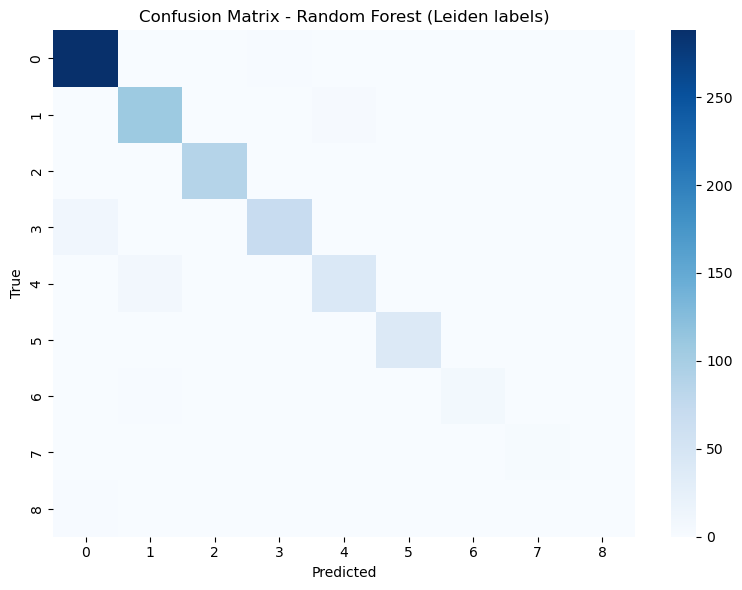

Saved: results/figures/confusion_rf.png


In [25]:
labels = np.unique(y)
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix - Random Forest (Leiden labels)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("results/figures/confusion_rf.png", dpi=200)
plt.show()

print("Saved: results/figures/confusion_rf.png")

In [27]:
genes = np.array(adata.var_names)
importances = rf.feature_importances_

imp_df = pd.DataFrame({"gene": genes, "importance": importances}).sort_values(
    "importance", ascending=False
)
imp_df.to_csv("results/metrics/rf_feature_importance.csv", index=False)

display(imp_df.head(20))
print("Saved: results/metrics/rf_feature_importance.csv")

,gene,importance
588,CD74,0.017447
1893,NKG7,0.017041
643,HLA-DRA,0.014737
1884,FTL,0.014090
1606,CCL5,0.013467
1847,TYROBP,0.013066
1103,FTH1,0.012957
651,HLA-DPA1,0.012147
151,FCER1G,0.012134
652,HLA-DPB1,0.011633


Saved: results/metrics/rf_feature_importance.csv


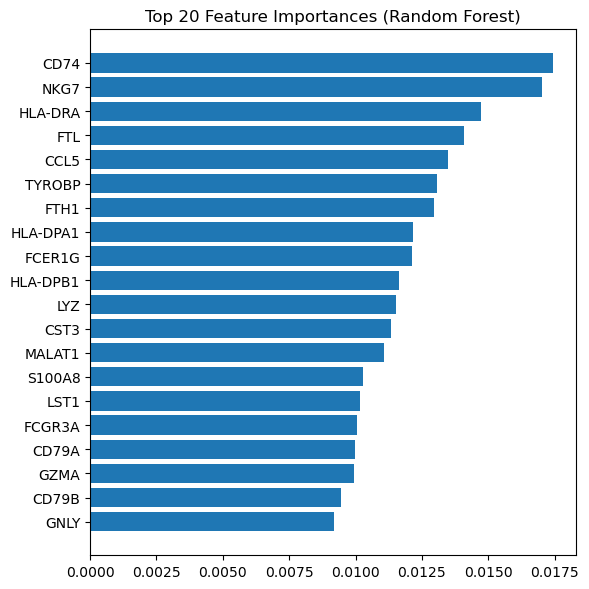

Saved: results/figures/rf_top20_genes.png


In [29]:
top20 = imp_df.head(20).iloc[::-1]

plt.figure(figsize=(6, 6))
plt.barh(top20["gene"], top20["importance"])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.savefig("results/figures/rf_top20_genes.png", dpi=200)
plt.show()

print("Saved: results/figures/rf_top20_genes.png")

In [31]:
joblib.dump(rf, "results/models/random_forest_model.joblib")
print("Saved: results/models/random_forest_model.joblib")

Saved: results/models/random_forest_model.joblib
